Text(0, 0.5, 'accuracy')

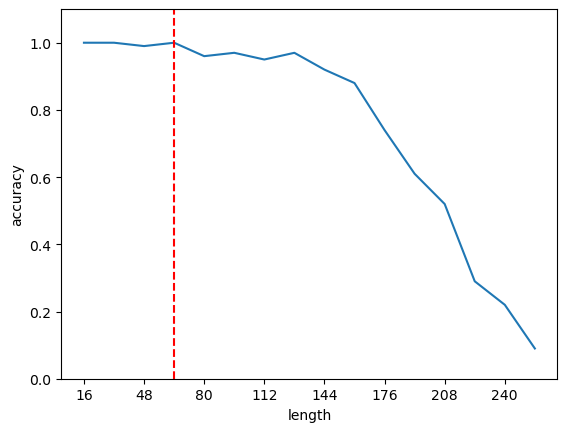

In [15]:
import wandb
import json

api = wandb.Api()
run = api.run('jackcai1206/mamba-arithmetic/t22nx70p')

config = json.loads(run.json_config)
lengths = range(config['n_digits_eval_start']['value'], config['n_digits_eval_end']['value'] + 1, config['n_digits_eval_step']['value'])
accs = []
for l in lengths:
    accs.append(run.summary[f'eval/{l}_accuracy'])
    

from matplotlib import pyplot as plt
plt.plot(lengths, accs)
plt.vlines(config['n_digits_train']['value'], 0, 1.1, linestyles='dashed', colors='r')
plt.xticks(lengths[::2])
plt.xlabel('length')
plt.ylim(0, 1.1)
plt.ylabel('accuracy')


In [3]:
import pstats
from pstats import SortKey
p = pstats.Stats('../out/abacus-384-6-6-1024-add-digits-20/profile')
p.sort_stats('cumtime').print_stats()


Sat Jul 20 04:07:06 2024    ../out/abacus-384-6-6-1024-add-digits-20/profile

         28477983 function calls (23814545 primitive calls) in 40.568 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   40.571   40.571 /opt/conda/lib/python3.11/site-packages/transformers/trainer.py:1784(train)
        1    0.016    0.016   40.571   40.571 /opt/conda/lib/python3.11/site-packages/transformers/trainer.py:1892(_inner_training_loop)
        2    0.000    0.000   19.152    9.576 /opt/conda/lib/python3.11/site-packages/transformers/trainer.py:2695(_maybe_log_save_evaluate)
      7/1    0.000    0.000   19.152   19.152 /opt/conda/lib/python3.11/site-packages/transformers/trainer_seq2seq.py:126(evaluate)
      7/1    0.000    0.000   19.152   19.152 /opt/conda/lib/python3.11/site-packages/transformers/trainer.py:3505(evaluate)
        6    0.000    0.000   19.104    3.184 /opt/conda/lib/python3.11/site-packa

In [22]:
from transformers import LlamaForCausalLM, LlamaConfig, TrainingArguments, Trainer, AutoTokenizer
from datasets import IterableDataset
import numpy as np

model_config = LlamaConfig(
    vocab_size=10,
    hidden_size=384,
    num_hidden_layers=6,
    num_attention_heads=6,
    intermediate_size=1024,
    max_position_embeddings=1024,
)
model = LlamaForCausalLM(model_config)
tokenizer = AutoTokenizer.from_pretrained('facebook/opt-125m')

def get_data1():
    for i in range(10000):
        yield {'input_ids': np.zeros(1024, dtype=int), 'labels': np.zeros(1024, dtype=int), 'attention_mask': np.zeros((1, 1024, 1024), dtype=float)}

def get_data2():
    for i in range(10000):
        yield {'input_ids': np.zeros(1024, dtype=int), 'labels': np.zeros(1024, dtype=int), 'attention_mask': np.zeros((1024), dtype=int)}
    
ds_slow = IterableDataset.from_generator(get_data1).with_format('torch')
ds_fast = IterableDataset.from_generator(get_data2).with_format('torch')

training_args = TrainingArguments(max_steps=1, output_dir='./out', report_to=None, per_device_train_batch_size=32, gradient_accumulation_steps=32)
trainer1 = Trainer(model, training_args, train_dataset=ds_slow, tokenizer=tokenizer)
trainer2 = Trainer(model, training_args, train_dataset=ds_fast, tokenizer=tokenizer)

import cProfile
cProfile.run('trainer1.train()', './test_slow.profile')
cProfile.run('trainer2.train()', './test_fast.profile')


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

max_steps is given, it will override any value given in num_train_epochs
max_steps is given, it will override any value given in num_train_epochs
/opt/conda/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss


/opt/conda/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss


In [28]:
import pstats

# compare the two profiles
p1 = pstats.Stats('./test_slow.profile')
p2 = pstats.Stats('./test_fast.profile')
p1.strip_dirs().sort_stats('cumtime').print_stats()


Fri Jul 19 21:26:03 2024    ./test_slow.profile

         1582200 function calls (1401111 primitive calls) in 340.112 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000  340.112  340.112 {built-in method builtins.exec}
        1    0.000    0.000  340.112  340.112 <string>:1(<module>)
        1    0.000    0.000  340.112  340.112 trainer.py:1784(train)
        1    0.017    0.017  340.112  340.112 trainer.py:1892(_inner_training_loop)
       33    0.001    0.000  326.171    9.884 data_loader.py:663(__iter__)
       33    0.001    0.000  325.473    9.863 data_loader.py:618(_fetch_batches)
 2486/265    0.001    0.000  325.428    1.228 {built-in method builtins.next}
       33    0.001    0.000  325.088    9.851 dataloader.py:625(__next__)
       33    0.725    0.022  325.083    9.851 dataloader.py:672(_next_data)
       33    0.002    0.000  323.988    9.818 fetch.py:24(fetch)
       33    0.000    

In [30]:
p2.strip_dirs().sort_stats('cumtime').print_stats()

Fri Jul 19 21:26:20 2024    ./test_fast.profile

         1567440 function calls (1386340 primitive calls) in 16.431 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   16.431   16.431 {built-in method builtins.exec}
        1    0.000    0.000   16.431   16.431 <string>:1(<module>)
        1    0.000    0.000   16.431   16.431 trainer.py:1784(train)
        1    0.018    0.018   16.431   16.431 trainer.py:1892(_inner_training_loop)
       32    0.003    0.000   14.327    0.448 trainer.py:3212(training_step)
       32    0.001    0.000    8.830    0.276 accelerator.py:2093(backward)
       32    0.000    0.000    8.829    0.276 _tensor.py:433(backward)
       32    0.000    0.000    8.829    0.276 __init__.py:149(backward)
       32    8.827    0.276    8.827    0.276 {method 'run_backward' of 'torch._C._EngineBase' objects}
       33    0.000    0.000    4.546    0.138 memory.py:147(empty_cache)